In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

warnings.simplefilter(action="ignore", category=FutureWarning)
import sys

sys.path.append("../")

import optuna

from straindesignxai.main import DataLoader

RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

C:\Users\mexis\AppData\Local\Temp\ipykernel_13756\1001373533.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Dataset size: (30, 10)
New data shape: (27, 10)


[12:14:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.



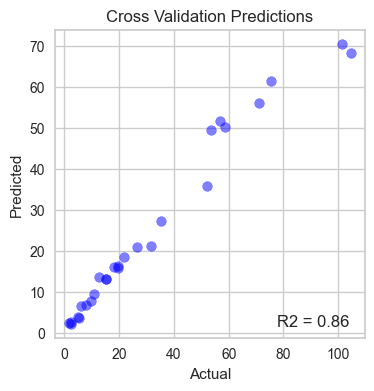

In [2]:
dl = DataLoader(PATH, INPUT_VARS, RESPONSE_VARS)
dl.get_bounds()

cycle = 'DBTL_A'
# cycle = 'all'

if cycle == 'DBTL_A':
    # Keep only DBTL_A indexes
    dl.df = dl.df[dl.df.index.isin(DBTL_A)]
    dl.X = dl.df[INPUT_VARS]
    dl.y = dl.df[RESPONSE_VARS]
    print(f"New data shape: {dl.df.shape}")

    try:
        dl.load_model("../models/xgb_limonene.pkl")
    except FileNotFoundError:
        dl.train_xgb(n_iter=300)
        dl.save_model("../models/xgb_limonene.pkl")

elif cycle == 'all':
    try:
        dl.load_model("../models/xgb_limonene_all.pkl")
    except FileNotFoundError:
        dl.train_xgb(n_iter=300)
        dl.save_model("../models/xgb_limonene_all.pkl")    
    
dl.plot_R2()

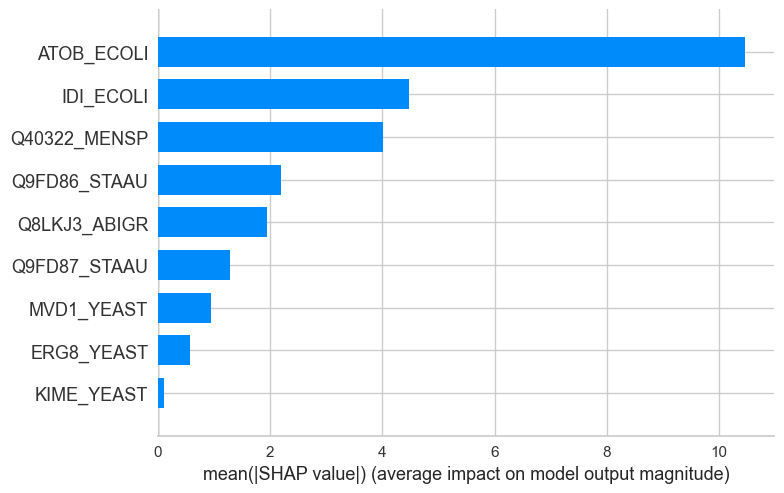

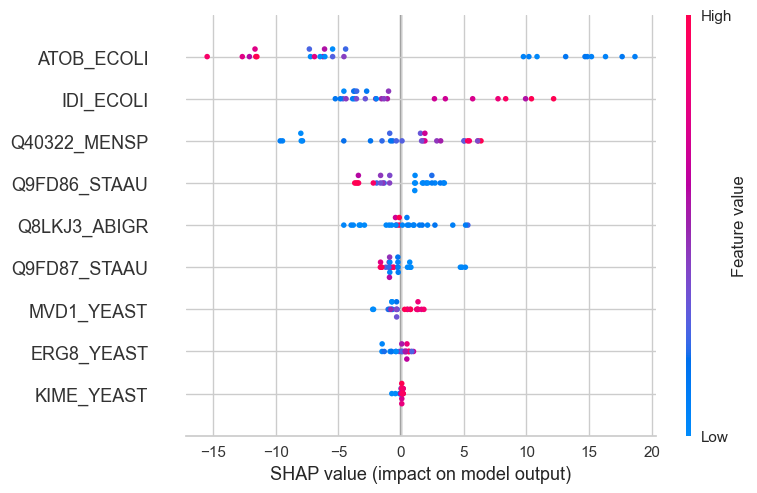

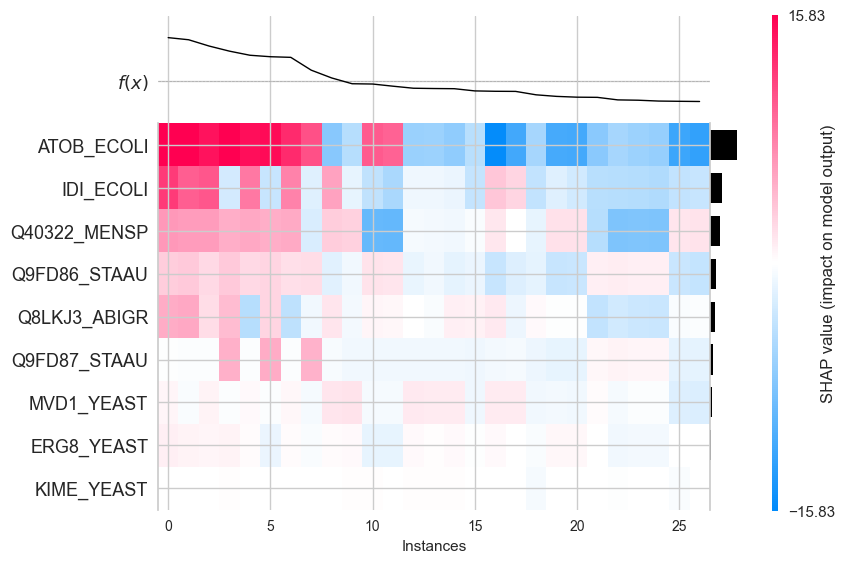

In [3]:
dl.get_shap_values()

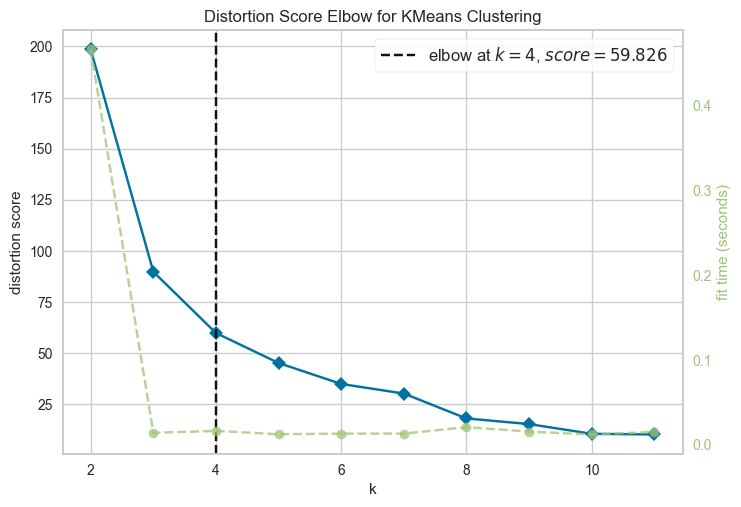

Optimal number of clusters: 4


In [4]:
dl.supervised_clustering()

In [5]:
dl.study_clusters()

Number of elements in each cluster: 
cluster
0    14
3     5
1     5
2     3
Name: count, dtype: int64


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
cluster,,,,,,,,,,
0,0.664971,0.666893,1.338579,0.254064,1.230621,3.749186,1.084307,1.563443,2.050229,10.931601
1,0.206480,0.707940,2.525160,0.330960,1.730520,8.523380,0.420080,0.540460,0.564080,78.341800
2,0.912200,0.707467,2.075733,0.308667,1.695533,4.429967,0.394533,2.661100,3.197000,21.957007
3,0.119180,0.311060,1.082380,0.151280,0.762520,3.047580,0.356020,0.160800,0.248800,46.023752


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
cluster,,,,,,,,,,
0,0.664971,0.666893,1.338579,0.254064,1.230621,3.749186,1.084307,1.563443,2.050229,10.931601
1,0.206480,0.707940,2.525160,0.330960,1.730520,8.523380,0.420080,0.540460,0.564080,78.341800
2,0.912200,0.707467,2.075733,0.308667,1.695533,4.429967,0.394533,2.661100,3.197000,21.957007
3,0.119180,0.311060,1.082380,0.151280,0.762520,3.047580,0.356020,0.160800,0.248800,46.023752


### Study top producting cluster

In [6]:
dl.df["pred"] = dl.model.predict(dl.df.drop(["Limonene", "cluster"], axis=1))
# find cluster with highest mean predicted value
top_cluster = (
    dl.df.groupby("cluster").mean().sort_values("pred", ascending=False).index[0]
)

dl.df[dl.df["cluster"] == top_cluster]

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene,cluster,pred
2X.Lm,0.1720,0.6213,2.5226,0.3043,1.6258,8.4749,0.2245,0.4305,0.4944,56.97134,1,51.756355
2X.Lh,0.2335,0.7463,2.3338,0.3196,1.7450,9.1728,0.2534,0.6998,0.6607,53.60310,1,49.505325
2X.Mm,0.2231,0.7901,2.7354,0.3744,1.9592,9.2338,0.4335,0.5118,0.5409,101.20540,1,70.643181
2X.Mh,0.2384,0.9413,3.1813,0.4010,2.1936,11.2037,0.2968,0.7816,0.7488,75.39261,1,61.636490
B.Ml,0.1654,0.4407,1.8527,0.2555,1.1290,4.5317,0.8922,0.2786,0.3756,104.53655,1,68.364120


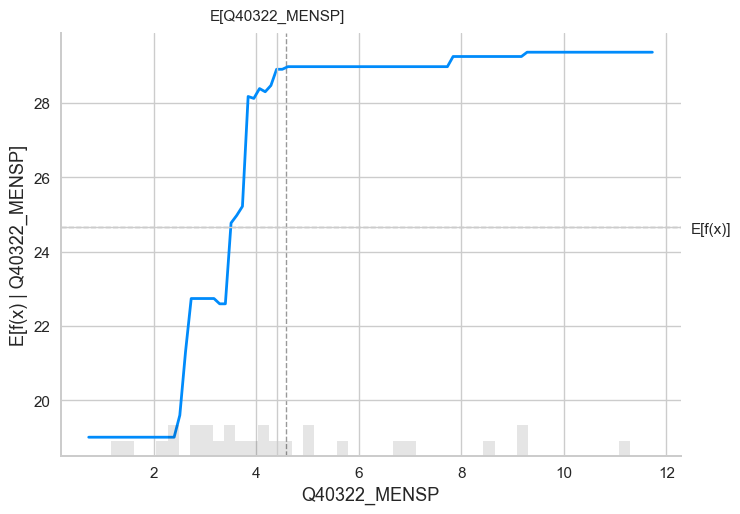

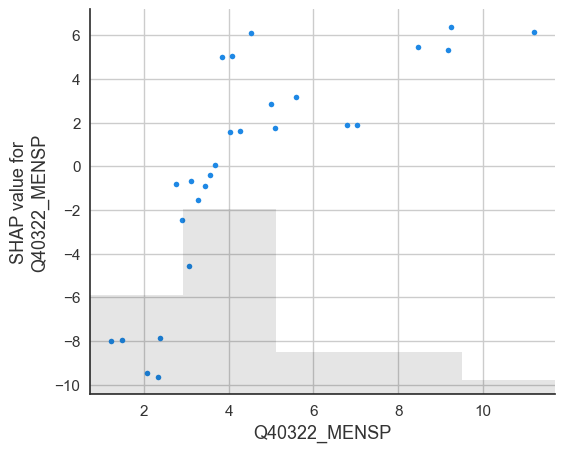

In [7]:
dl.pdplot("Q40322_MENSP")
dl.shap_scatter("Q40322_MENSP")

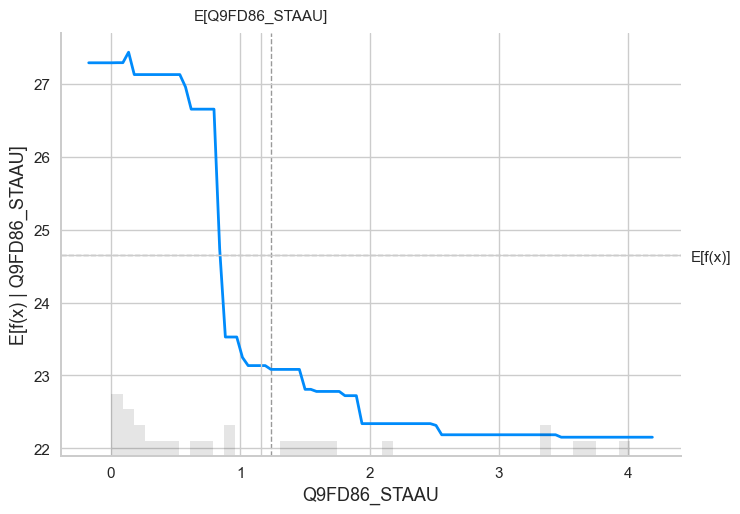

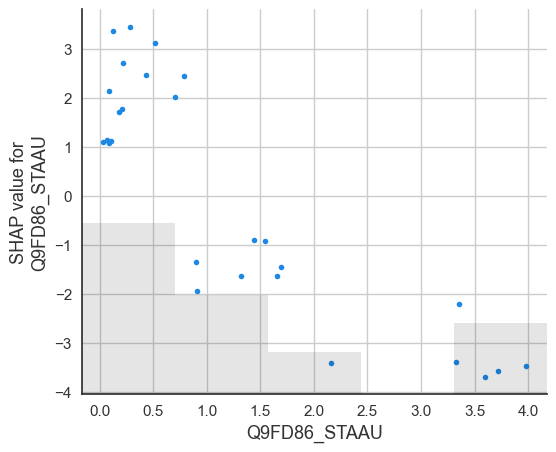

In [8]:
dl.pdplot("Q9FD86_STAAU")
dl.shap_scatter("Q9FD86_STAAU")

## Sampling

In [9]:
from scipy.stats import qmc

# Rearrange bounds to match input variables
# dl.bounds['Q40322_MENSP'].loc['min'] = 14
# dl.bounds['Q9FD86_STAAU'].loc['max'] = 0.3
# dl.bounds['ERG8_YEAST'].loc['max'] = 0.5

sampler = qmc.LatinHypercube(d=dl.X.shape[1])
sample = sampler.random(100)
LB = dl.bounds.T['min'].values.tolist()
UB = dl.bounds.T['max'].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=dl.X.columns)
sample_df["pred"] = dl.model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
42,0.141547,1.213503,2.314672,1.117018,2.376299,9.485519,1.143637,0.177682,2.359417,69.368492
92,0.169033,0.416852,2.268795,0.498376,3.878935,8.627653,0.355613,3.762295,1.657505,60.655151
41,0.118624,1.331137,1.975141,1.461907,3.916754,8.367246,1.660791,1.425845,3.840605,59.295074
5,0.046863,1.371050,2.233526,1.217685,3.097419,13.249251,2.110188,3.148502,4.876703,51.009048
44,0.294119,0.884491,2.008989,0.893198,2.560113,12.684214,0.253719,0.795076,4.157429,48.228870
...,...,...,...,...,...,...,...,...,...,...
26,1.342788,1.335256,1.755088,0.767858,1.424589,3.888483,4.385764,2.859485,4.403703,8.129781
69,1.383482,1.396955,0.845263,0.542131,0.444893,13.442849,1.072958,1.065787,4.464023,7.337861
18,1.417073,1.010944,1.091900,1.102492,0.827998,3.550114,3.633445,3.987587,3.561332,6.819738
38,1.208797,0.789240,1.135633,1.210990,1.116049,11.237308,4.048883,3.329241,1.448213,6.556748
